In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations

Define number of particles and get random position (between 0 and 1) for each particle

In [3]:
n_particles = 400
r = np.random.random((2, n_particles))

In [4]:
# colouring the particles based on the initial direction of motion
ixr = r[0] > 0.5 #right
ixl = r[0] <= 0.5 #left


Give IDs to each particle (this will come in handy later)

In [5]:
ids = np.arange(n_particles)

Plot initial configuration of particles

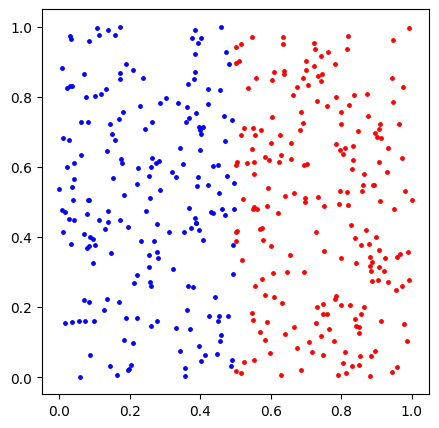

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(r[0][ixr], r[1][ixr], color='r', s=6)
plt.scatter(r[0][ixl], r[1][ixl], color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

- __Note__: We're using the assumption that particles in a gas move at approximately 500m/s

In [9]:
v = np.zeros((2, n_particles))
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be

## Part 1: Distance Between all Pairs
- To determine if two particles collide, we need to find the distance between __all pairs__ of particles. If the distance is less than 2 times radius of each particle, they collide. If there are n particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [10]:
ids_pairs = np.asarray(list(combinations(ids, 2)))

We can obtain distances between particles in a similar fashion
- First get the pairs of x-position of all particles

In [11]:
x_pairs = np.asarray(list(combinations(r[0], 2)))

- then take the difference to get $\Delta x_{ij}$ of all pairs

In [13]:
dx_pairs = np.diff(x_pairs, axis=1).ravel()

The total distance is just $d_{ij} = \sqrt{\Delta x^2_{ij} + \Delta y^2_{ij}}$. Since there are $n(n-1)/2$ different values of $d_{ij}$

In [17]:
x_pairs = np.asarray(list(combinations(r[0], 2)))
y_pairs = np.asarray(list(combinations(r[1], 2)))

dx_pairs = np.diff(x_pairs, axis=1).ravel()
dy_pairs = np.diff(y_pairs, axis=1).ravel()

d_pairs = np.sqrt(dx_pairs**2 + dy_pairs**2)

## Part 2: Velocities of a Collision
So at each iteration of the simulation, we will evaluate d_pairs, and if any of the distances between particles is less than 2r, then a collision occurs, What is the final velocity of each of the two spheres? In an elastic collision one can show
$$\vec{v_1} = \vec{u_1} - \frac{(\vec{u_1} - \vec{u_2})\cdot(\vec{r_1} - \vec{r_2})}{|\vec{r_1} - \vec{r_2}|^2} (\vec{r_1} - \vec{r_2})$$

$$\vec{v_2} = \vec{u_2} - \frac{(\vec{u_2} - \vec{u_1})\cdot(\vec{r_2} - \vec{r_1})}{|\vec{r_1} - \vec{r_2}|^2} (\vec{r_2} - \vec{r_1})$$

In [19]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]

We will call all the particles in the left column "1" and the right column "2"

In [20]:
v1 = v[:, ids_pairs_collide[:, 0]]
v2 = v[:, ids_pairs_collide[:, 1]]
r1 = r[:, ids_pairs_collide[:, 0]]
r2 = r[:, ids_pairs_collide[:, 1]]

Then we compute the new velocity

In [21]:
v1new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)

v2new = v2 - np.diag((v2-v1).T@(r2-r1))/np.sum((r1-r2)**2, axis=0) * (r2-r1)

## Part 3: Functions to Run the Simulation
Here we define some function that will help make running the simulation easier


In [39]:
def get_delta_pairs(x):
    return np.diff(np.asarray(list(combinations(x,2))), axis=1).ravel()

def get_deltad_pairs(r):
    return np.sqrt(get_delta_pairs(r[0])**2 + get_delta_pairs(r[1])**2)

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - np.diag((v2-v1).T@(r2-r1))/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        ic = id_pairs[get_deltad_pairs(r) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -np.abs(v[0,r[0]>1])
        v[0,r[0]<0] = np.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -np.abs(v[1,r[1]>1])
        v[1,r[1]<0] = np.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array rs where each axis is $(t, x, y)$)